In [2]:
from modules import *
from functions import *

In [3]:
""" Multiple neurons """

N = int(1000)     

theta_stim = 90
n_trials = 50
n_thetas = 100
n_test_angles = 500
init_trials = 10

rand_scaling = 1
hebb_scaling = 0.3
a=10
b=10

vars = np.random.lognormal(2, 0.6, N)
learning_rate = 1

W_init = initialise_W(N, vars)

# Settle to a baseline
# for trial in range(init_trials):
#     w = W_init
#     H = hebbian_component(N, w, n_thetas, theta_stim, type='baseline')
#     eta = np.random.randn(N, N)
#     W_init = w + (hebb_scaling * H * propensity_hebb(w, a) + rand_scaling * eta * propensity_rand(w, b)) * learning_rate
#     normalisation(W_init)

POs = []; ratios = []
W = np.zeros((N, N, n_trials+1))
W[:, :, 0] = W_init

# Run trials
for trial in range(n_trials):
    W_old = W[:, :, trial]

    H = hebbian_component(N, W_old, n_thetas, theta_stim, type='stripe_rearing')
    eta = abs(np.random.randn(N, N))
    hebb = hebb_scaling * H * propensity_hebb(W_old, a)
    rand = rand_scaling * eta * propensity_rand(W_old, b)
    W_new = W_old + (hebb + rand) * learning_rate
    ratios.append(np.mean(hebb) / (np.mean(rand) + 10e-10))
    normalisation(W_new)
    W[:, :, trial+1] = W_new
    PO = get_preferred_orientations(N, W_old, n_angles=n_test_angles); POs.append(PO)

print('Median ratio: ', np.median(ratios))

preferences = np.array(POs).T 
initial_preferences = np.linspace(0, 180, N) # preferences[:, 0];
final_preferences = preferences[:, -1]
absolute_change = np.array([circular_distance(preferences[:, day], initial_preferences) for day in range(n_trials)])
median_change_per_day = np.array([np.median(x) for x in absolute_change])
std_change_per_day = np.array([np.std(x) for x in absolute_change])

KeyboardInterrupt: 

In [55]:
def plot_weights(trial=20, vmax=0.04):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.4), dpi=180)
    im = axs[0].imshow(W[:, :, trial],vmin=0, vmax=vmax)
    axs[0].set_xticks([0, N/2, N-1]); axs[0].set_yticks([0, N/2, N-1])
    axs[0].set_xticklabels([0, 90, 180]); axs[0].set_yticklabels([0, 90, 180])
    axs[0].set_xlabel(r'post', fontstyle='italic')
    axs[0].set_ylabel(r'pre', fontstyle='italic')
    axs[0].invert_yaxis()

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.locator_params(nbins=2)
    # cbar.formatter.set_powerlimits((0, 0))
    
    axs[1].scatter(preferences[:, 0], preferences[:, trial], s=20, alpha=0.2, fc='midnightblue', ec=None)
    axs[1].set_ylabel('PO day {}'.format((0+trial), fontsize=12, labelpad=15))
    axs[1].set_xlabel('PO day 1', labelpad=15)
    axs[1].set_xticks([0, 90, 180]); axs[1].set_yticks([0, 90, 180])
    axs[1].set_xticklabels(['-90', '0', '+90']); axs[1].set_yticklabels(['-90', '0', '+90'])

    axs[2].plot(median_change_per_day[:trial+1], c='k', ls='-', marker='o', ms=4)
    axs[2].set_ylim([0, 10])
    axs[2].locator_params(axis='y', nbins=2)
    axs[2].set_xlabel('Days'); axs[2].set_xlim(0, n_trials)
    axs[2].set_ylabel(r'Median $ | \Delta PO | \; [\degree]$')
    
    ax2 = axs[2].twinx()
    ax2.spines['right'].set_color('r'); ax2.tick_params(axis='y', colors='r')
    ax2.plot(ratios[:trial], c='r', alpha=0.5)
    ax2.set_ylim(0, 1);
    ax2.set_ylabel('Ratio', color='r', rotation=270, labelpad=15)
    sns.despine(ax=ax2, right=False)

    fig.tight_layout(pad=2.5)
    
interact(plot_weights, trial=(0, n_trials-1), vmax=(0, 0.1, 0.001));

interactive(children=(IntSlider(value=20, description='trial', max=49), FloatSlider(value=0.04, description='v…

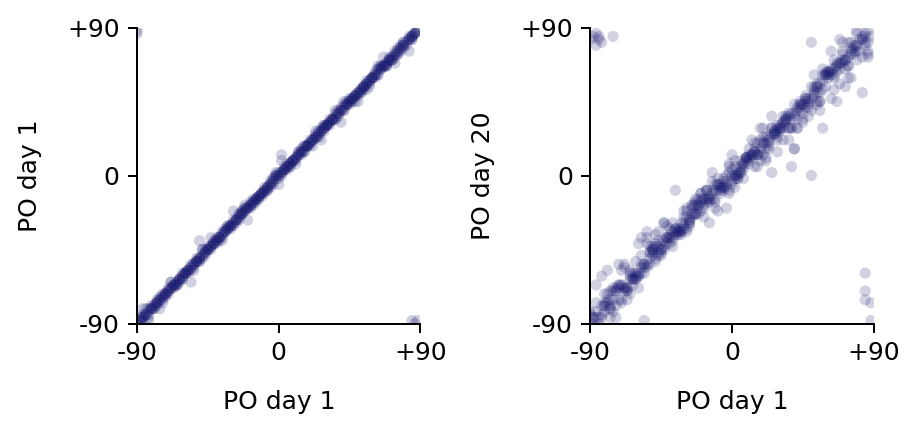

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.2, 2.5), dpi=180)

color = 'midnightblue'
start = 1; end = 20
y_labels = ['PO day {}'.format((0+start)), 'PO day {}'.format((0+end))]

ax1.scatter(preferences[:, 0], preferences[:, start], s=20, alpha=0.2, fc=color, ec=None)
ax2.scatter(preferences[:, 0], preferences[:, end], s=20, alpha=0.2, fc=color, ec=None)

# ax1.scatter(preferences[:, :-start], preferences[:, start:], s=20, alpha=0.1, fc=color, ec=None)
# ax2.scatter(preferences[:, :-end], preferences[:, end:], s=20, alpha=0.1, fc=color, ec=None)

for i, ax in enumerate([ax1, ax2]):
    ax.set_ylabel(y_labels[i])
    ax.set_xlabel('PO day 1') 
    ax.set_xticks([0, 90, 180]); ax.set_yticks([0, 90, 180])
    ax.set_xticklabels(['-90', '0', '+90']); ax.set_yticklabels(['-90', '0', '+90'])
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.6)
# plt.savefig('figures/baseline_scatter.svg')


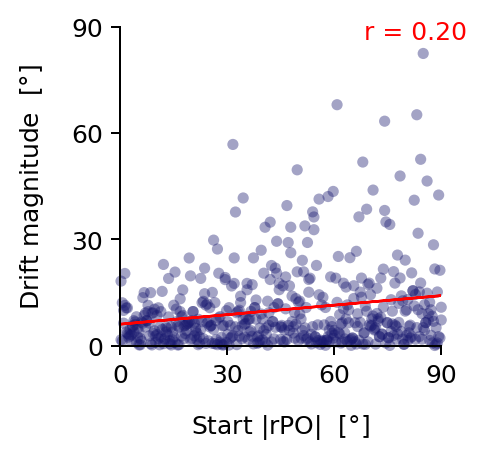

In [57]:
initial_distances = np.abs(initial_preferences - theta_stim)
final_distances = np.abs(final_preferences - theta_stim)
change = initial_distances - final_distances
total_drift = circular_distance(initial_preferences, final_preferences)

fig, ax = plt.subplots(figsize=(2.3, 2.3), dpi=180)
ax.scatter(initial_distances, total_drift, s=20, color=color, ec=None, clip_on=False, alpha=0.4)
ax.set_yticks(np.arange(0, 91, 30)); ax.set_xticks(np.arange(0, 91, 30))
ax.set_xlim(0, 90); ax.set_ylim(0, 90)
ax.set_xlabel(r'Start |rPO|  $[\degree]$')
ax.set_ylabel(r'Drift magnitude  $[\degree]$')

# plot correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(initial_distances, total_drift)
ax.plot(initial_distances, intercept + slope*initial_distances, 'r', lw=1, alpha=1)
textstr = r'r = %.2f' % (r_value); ax.text(0.76, 0.96, textstr, transform=ax.transAxes, fontsize=10); ax.texts[0].set_color('r')

# plt.savefig('figures/deprivation_magnitude_scatter.svg')

In [58]:
r_value, p_value 

(0.20356940228835438, 4.460310616813388e-06)

Text(0, 0.5, '$ \\Delta |rPO | \\; [\\degree]$')

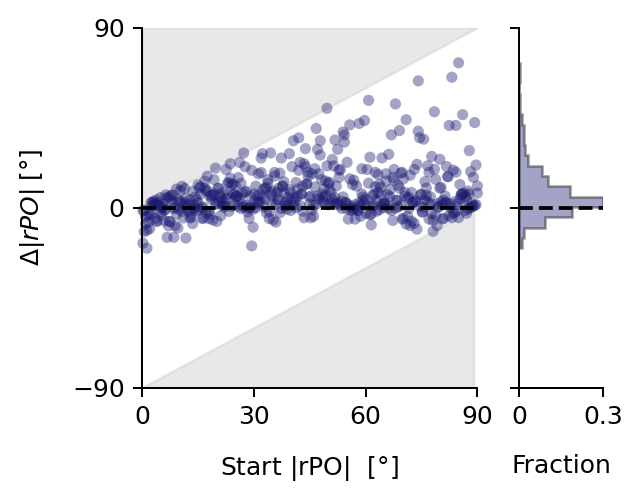

In [59]:
fig = plt.figure(figsize=(3.2, 2.5), dpi=180)

gs = fig.add_gridspec(1, 2,  width_ratios=(4, 1),  left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.05)
ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1], sharey=ax)

ax.fill_between(np.arange(0, 91, 1), np.arange(0, 91, 1), 90, color='lightgray', alpha=0.5) 
ax.fill_between(np.arange(0, 90, 1), np.arange(-90, 0, 1), -90, color='lightgray', alpha=0.5)
ax.axhline(0, ls='--', color='k')
ax_hist.axhline(0, ls='--', color='k')

ax.scatter(initial_distances, change, s=20, color=color, ec=None, clip_on=False, alpha=0.4)
ax_hist.hist(change, bins=18, orientation="horizontal", histtype="stepfilled", alpha=0.4, ec='k', fc=color)

xlim = ax_hist.get_xlim()[1]
ax_hist.set_xticks([0, xlim])
ax_hist.set_xticklabels([0, np.round(xlim / N, 1)])
ax_hist.set_xlabel('Fraction')
ax_hist.tick_params(axis="y", labelleft=False)

ax.set_yticks(np.arange(-90, 91, 30)); ax.set_xticks(np.arange(0, 91, 30))
ax.set_xlim(0, 90); ax.set_ylim(-90, 90); ax.set_yticks(np.arange(-90, 91, 90))
ax.set_xlabel(r'Start |rPO|  $[\degree]$')
ax.set_ylabel(r'$ \Delta |rPO | \; [\degree]$')
# ax.set_title(r'Change in distance from $\bf{\hat{\theta}}$', fontsize=13, fontweight='bold', pad=15)

# plt.savefig('figures/deprivation_direction_scatter.svg')

Text(0, 0.5, 'Drift rate  $[\\degree]$')

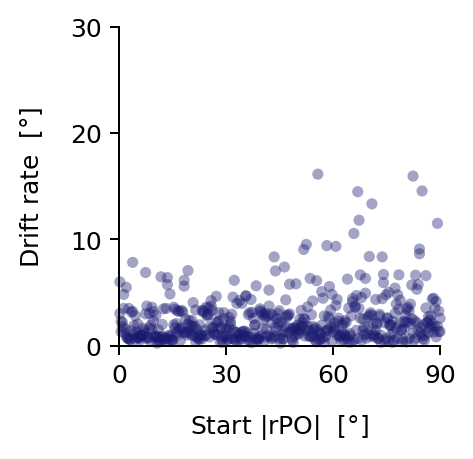

In [60]:
drift_rates = np.mean(np.array([circular_distance(preferences[:, x+1], preferences[:, x]) for x in range(n_trials-1)]), axis=0)

fig, ax = plt.subplots(figsize=(2.3, 2.3), dpi=180)
ax.scatter(initial_distances, drift_rates, s=20, color=color, ec=None, clip_on=False, alpha=0.4)
ax.set_yticks(np.arange(0, 91, 10))
ax.set_xticks(np.arange(0, 91, 30))
ax.set_xlim(0, 90); ax.set_ylim(0, 30)
ax.set_xlabel(r'Start |rPO|  $[\degree]$')
ax.set_ylabel(r'Drift rate  $[\degree]$')
# ax.set_title(r'Drift rate vs distance from $\bf{\hat{\theta}}$', fontsize=13, fontweight='bold', pad=15)

# plot correlation
# slope, intercept, r_value, p_value, std_err = stats.linregress(initial_distances, drift_rates)
# ax.plot(initial_distances, intercept + slope*initial_distances, 'r', lw=1, alpha=1)
# textstr = r'r = %.2f' % (r_value); ax.text(0.76, 0.96, textstr, transform=ax.transAxes, fontsize=10); ax.texts[0].set_color('r')

# plt.savefig('figures/deprivation_drift_rate_scatter.svg')

Text(0.5, 0, 'Tuning curve width  $ \\; [\\degree]$')

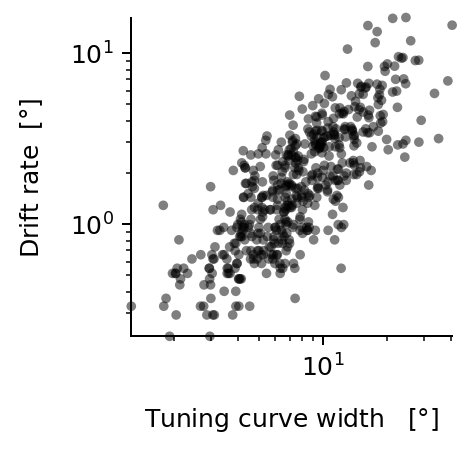

In [61]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), dpi=180)
ax.scatter(vars, drift_rates, s=15, color='k', ec=None, clip_on=False, alpha=0.5)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(r'Drift rate $ \; [\degree]$')
ax.set_xlabel(r'Tuning curve width  $ \; [\degree]$')

# # plot correlation
# slope, intercept, r_value, p_value, std_err = stats.linregress(vars, drift_rates)
# ax.plot(initial_distances, intercept + slope*initial_distances, 'r', lw=1, alpha=1)
# textstr = r'r = %.2f' % (r_value); ax.text(0.76, 0.96, textstr, transform=ax.transAxes, fontsize=10); ax.texts[0].set_color('r')

# plt.savefig('figures/tuning_width_drift_rate.svg')

Text(0, 0.5, 'Cumulative prob.')

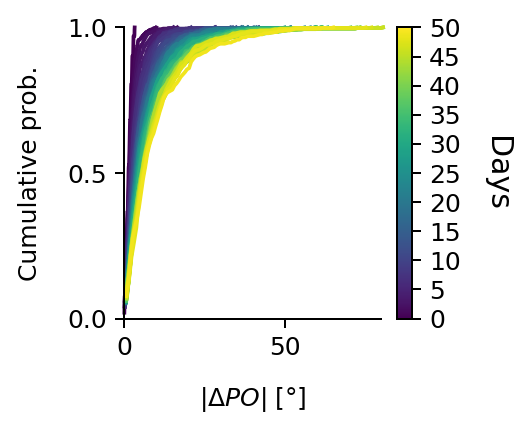

In [62]:
fig, ax = plt.subplots(figsize=(2.3, 2.1), dpi=180)


cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, n_trials)]

for i in range(0, n_trials-1, 1):
    count, bins_count = np.histogram(absolute_change[i], bins=100)
    pdf = count / sum(count); cdf = np.cumsum(pdf)
    ax.plot(bins_count[1:], cdf, c=colors[i], label='Day {}'.format(i+1), clip_on=False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=n_trials))
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(0, n_trials+5, 5))
cbar.ax.set_yticklabels(np.arange(0, n_trials+5, 5))
cbar.set_label('Days', rotation=270, labelpad=20, fontsize=12)
ax.set_xlim([0, 80])
ax.set_ylim([0, 1]); ax.set_yticks(np.arange(0, 1.1, 0.5))

ax.set_xlabel(r'$| \Delta PO | \; [\degree]$')
ax.set_ylabel('Cumulative prob.')
# ax.set_title(r'Cumulative distribution of $| \Delta PO |$', fontsize=13, fontweight='bold', pad=15)

# plt.savefig('figures/cumulative_prob.svg')

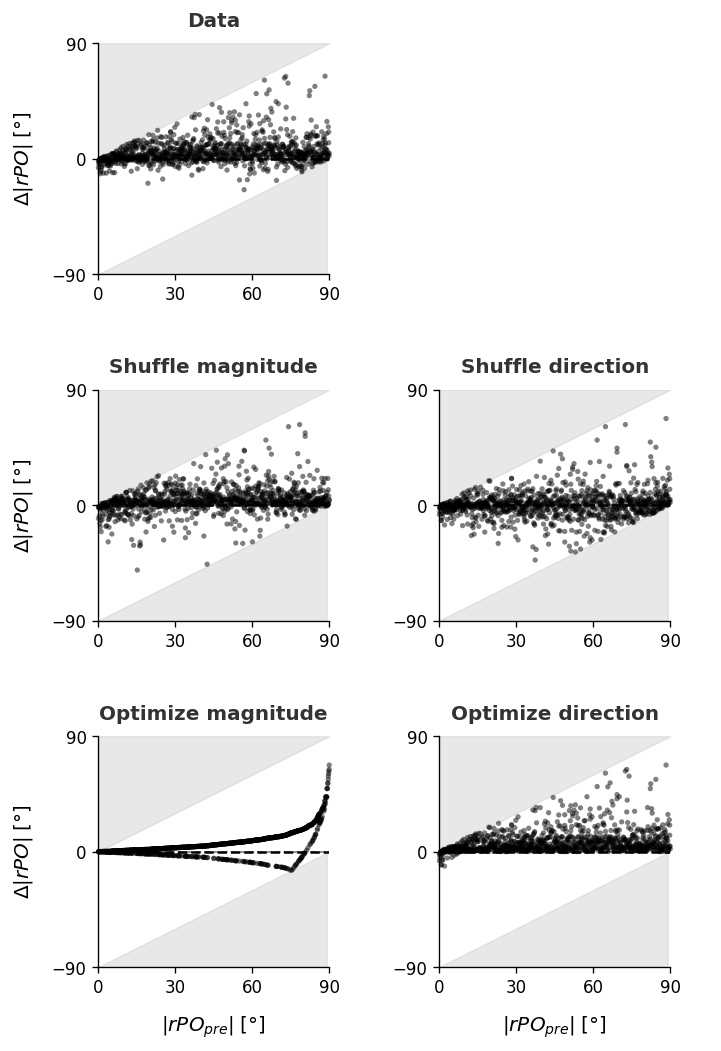

In [85]:
PO = preferences
PO[:, 0] = np.linspace(0, 180, N)
dPO = []                                          # change in preference at each time step 
rPO = []                                          # relative preference at each time step
dPO_ShM = []                                      # shuffled magnitude
dPO_ShD = []                                      # shuffled direction
dPO_OpM = np.zeros((PO.shape[1],PO.shape[0]))     # optimized magnitude
dPO_OpD = []                                      # optimized direction
for i in range(n_trials): 
    dPO.append(directional_circular_distance(PO[:,i], PO[:,0]))
    rPO.append(PO[:,i] - theta_stim)
    dPO_ShM.append(np.random.permutation(np.abs(dPO[i])) * (np.sign(dPO[i])+(dPO[i]==0)))   # permute the value, keep the sign 
    dPO_ShD.append(np.random.permutation(np.sign(dPO[i])+(dPO[i]==0)) * np.abs(dPO[i]))     # permute the sign, keep the value
    sorted_dPO = np.sort(np.abs(dPO[i]))
    order_start_rPO = np.argsort(np.abs(rPO[0]))
    dPO_OpM[i,order_start_rPO]=sorted_dPO
    dPO_OpM[i,:] = dPO_OpM[i,:]* (np.sign(dPO[i])+(dPO[i]==0))                              # give furthest POs the most change 
    dPO_OpD.append(np.abs(dPO[i]) * -1*(np.sign(rPO[0])+(rPO[0]==0)))                       # always move in the direction of stimulus angle

dPO, rPO, dPO_ShM, dPO_ShD, dPO_OpM, dPO_OpD = convert_to_array(dPO, rPO, dPO_ShM, dPO_ShD, dPO_OpM, dPO_OpD)

# final preferences after shuffling 
PO_ShM = (PO[:,0]+dPO_ShM)  
PO_ShD = (PO[:,0]+dPO_ShD)
PO_OpM = (PO[:,0]+dPO_OpM)
PO_OpD = (PO[:,0]+dPO_OpD)

PO_ShM, PO_ShD, PO_OpM, PO_OpD = convert_to_array(PO_ShM, PO_ShD, PO_OpM, PO_OpD)

rPO_ShM, rPO_ShD, rPO_OpM, rPO_OpD = [directional_circular_distance(x, theta_stim) for x in (PO_ShM, PO_ShD, PO_OpM, PO_OpD)]       # relative distances after shuffling
drPO, drPO_ShM, drPO_ShD, drPO_OpM, drPO_OpD = [np.abs(rPO[0]) - np.abs(x) for x in (rPO, rPO_ShM, rPO_ShD, rPO_OpM, rPO_OpD)]      # change in relative distance after shuffling


fig, axs = plt.subplots(3, 2, figsize=(7, 10), dpi=120) 
axes = axs.flatten()
changes = [drPO, [],  drPO_ShM, drPO_ShD, drPO_OpM, drPO_OpD]

titles = ['Data', [], 'Shuffle magnitude', 'Shuffle direction', 'Optimize magnitude', 'Optimize direction']

for i, ax in enumerate(axes):
    if i != 1:

        ax.fill_between(np.arange(0, 91, 1), np.arange(0, 91, 1), 90, color='lightgray', alpha=0.5) 
        ax.fill_between(np.arange(0, 90, 1), np.arange(-90, 0, 1), -90, color='lightgray', alpha=0.5)
        ax.axhline(0, ls='--', color='k')
        # ax_hist.axhline(0, ls='--', color='k')

        ax.scatter(np.abs(rPO[0]), changes[i][n_trials-1, :], s=10, color='k', ec=None, clip_on=False, alpha=0.5)
        # ax.scatter(np.abs(rPO[0]), changes[i][n_trials-1, :], s=10, color=colors[i], ec=None, clip_on=False, alpha=0.5)
        ax.set_title(titles[i], fontsize=12, fontweight='bold', pad=10)
        ax.set_yticks(np.arange(-90, 91, 90))
        ax.set_xticks(np.arange(0, 91, 30))
        ax.set_xlim(0, 90); ax.set_ylim(-90, 90)
        ax.set_aspect(0.5, adjustable='box')
        ax.axhline(0, c='k', ls='--', alpha=0.5, lw=1)      

    if i in (0, 2, 4):
        ax.set_ylabel(r'$\Delta |rPO| \; [\degree]$', fontsize=12, labelpad=10)
    if i in (4, 5):
        ax.set_xlabel(r'$|rPO_{pre}| \; [\degree]$', fontsize=12, labelpad=10)
    if i == 1:
        ax.axis('off')

fig.subplots_adjust(wspace=0.1, hspace=0.5)

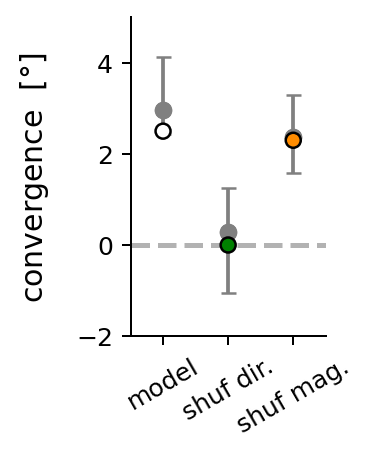

In [34]:
color_model = 'white'
color_mag = 'green'
color_dir = 'darkorange'

colors = [color_model, color_mag, color_dir]

data = [2.9706, 0.2923,	2.3746]
lower_bound = [0.5411,	1.3523, 0.7938]
upper_bound = [1.1688, 0.951, 	0.914]

day = 31

fig, ax = plt.subplots(1, 1, figsize=(1.4, 2.3), dpi=180)

ax.scatter([0, 1, 2], [np.median(drPO[day]), np.median(drPO_ShD[day]), np.median(drPO_ShM[day])]  s=50, ec='k', fc="None", zorder=3)
ax.errorbar([0, 1, 2], [np.median(drPO), np.median(drPO_ShD), np.median(drPO_ShM)], yerr=[np.std(drPO), np.std(drPO_ShD), np.std(drPO_ShM)], fmt='o', c='k', alpha=0.6, capsize=3)

plt.scatter([0, 1, 2], data, fc='gray', ec='gray', alpha=1, zorder=3)
plt.errorbar([0, 1, 2], data, yerr=[lower_bound, upper_bound], fmt='o', c='gray', alpha=1, capsize=3)

ax.set_xticks([0, 1, 2], ['model', 'shuf dir.', 'shuf mag.'], rotation=30);
ax.set_ylabel(r'convergence  $[\degree]$', fontsize=12, labelpad=10)
ax.axhline(0, c='k', ls='--', alpha=0.3, lw=2)
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([-2, 5])


plt.savefig('figures/shuffle_plot.svg')

In [73]:
Model1 = np.median(drPO,axis=1)
ShM1 = np.median(drPO_ShM,axis=1)
OpM1 = np.median(drPO_OpM,axis=1)
ShD1 = np.median(drPO_ShD,axis=1)
OpD1 = np.median(drPO_OpD,axis=1)

In [83]:
Model2 = np.median(drPO,axis=1)
ShM2 = np.median(drPO_ShM,axis=1)
OpM2 = np.median(drPO_OpM,axis=1)
ShD2 = np.median(drPO_ShD,axis=1)
OpD2 = np.median(drPO_OpD,axis=1)

In [87]:
Model3 = np.median(drPO,axis=1)
ShM3 = np.median(drPO_ShM,axis=1)
OpM3 = np.median(drPO_OpM,axis=1)
ShD3 = np.median(drPO_ShD,axis=1)
OpD3 = np.median(drPO_OpD,axis=1)

In [100]:
Model4 = np.median(drPO,axis=1)
ShM4 = np.median(drPO_ShM,axis=1)
OpM4 = np.median(drPO_OpM,axis=1)
ShD4 = np.median(drPO_ShD,axis=1)
OpD4 = np.median(drPO_OpD,axis=1)

In [101]:
Model_mean = np.mean(np.vstack((Model1, Model2, Model3, Model4)), axis=0)
ShM_mean = np.mean(np.vstack((ShM1, ShM2, ShM3, ShM4)), axis=0)
OpM_mean = np.mean(np.vstack((OpM1, OpM2, OpM3, OpM4)), axis=0)
ShD_mean = np.mean(np.vstack((ShD1, ShD2, ShD3, ShD4)), axis=0)
OpD_mean = np.mean(np.vstack((OpD1, OpD2, OpD3, OpD4)), axis=0)

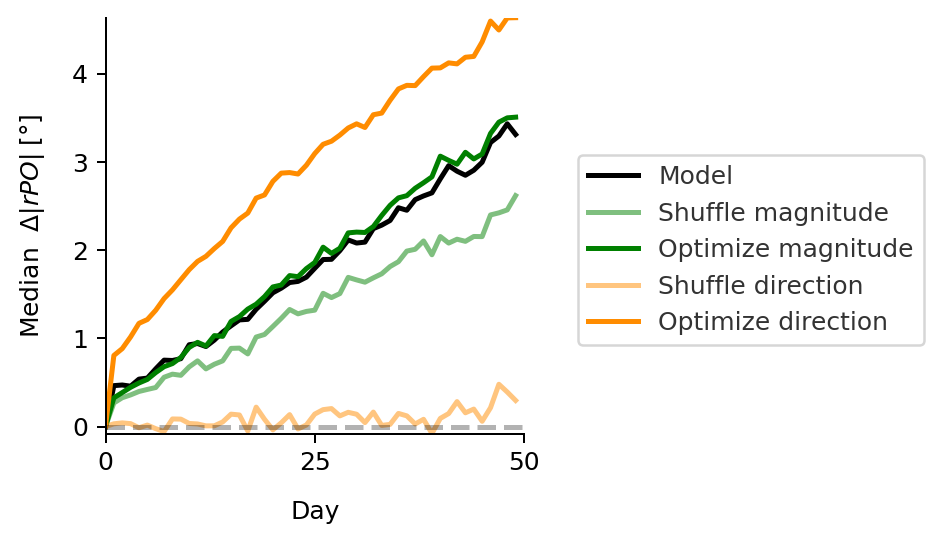

In [104]:
color_model = 'black'

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=180)

# ax.plot(np.median(drPO,axis=1), lw=2, c=color_model, label='Model')                                               # median change in relative distance over time
# ax.plot(np.median(drPO_ShM,axis=1), lw=2, c=color_mag, alpha=0.5, label='Shuffle magnitude')
# ax.plot(np.median(drPO_OpM,axis=1), lw=2, c=color_mag, label='Optimize magnitude')
# ax.plot(np.median(drPO_ShD,axis=1), lw=2, c=color_dir, alpha=0.5, label='Shuffle direction')
# ax.plot(np.median(drPO_OpD,axis=1), lw=2, c=color_dir, label='Optimize direction')

ax.plot(Model_mean, lw=2, c=color_model, label='Model')                                               # median change in relative distance over time
ax.plot(ShM_mean, lw=2, c=color_mag, alpha=0.5, label='Shuffle magnitude')
ax.plot(OpM_mean, lw=2, c=color_mag, label='Optimize magnitude')
ax.plot(ShD_mean, lw=2, c=color_dir, alpha=0.5, label='Shuffle direction')
ax.plot(OpD_mean, lw=2, c=color_dir, label='Optimize direction')


ax.axhline(0, c='k', ls='--', alpha=0.3, lw=2)
ax.set_ylabel(r'Median  $ \Delta |rPO | \; [\degree]$')
ax.set_xlabel('Day')
ax.set_xticks([0, 25, 50])
# ax.legend()
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 0.7), fontsize=10, frameon=True) #, labelspacing=0.2, handletextpad=0.2, borderpad=0.2)

np.savetxt('Model_mean', Model_mean, delimiter=",")
np.savetxt('ShM_mean', ShM_mean, delimiter=",")
np.savetxt('OpM_mean', OpM_mean, delimiter=",")
np.savetxt('ShD_mean', ShD_mean, delimiter=",")
np.savetxt('OpD_mean', OpD_mean, delimiter=",")

plt.savefig('figures/shuffle_vs_time.svg')